# Target: IC 5146 (Cocoon nebula)

![Image not found](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/IC5146_The_Cocoon_Nebula.jpg/1200px-IC5146_The_Cocoon_Nebula.jpg)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import brentq
from IPython.display import display, Latex

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

## Properties of the target

In [2]:
# Right Ascension = 21h 53m 29.3s
# Declination =    +47° 14’ 46”

Radius = 5*60       # in arcsec (we approximate the nebula to be circular)
Magnitude_V = 7.2   # in the V-band
lambda_V = 5510     # pivot wavelength of the V-band in Angstrom

<font color='red'>We only have the magnitude in the V-band (pivot wavelength = 5510 A, fwhm = 880 A).</font>\
<font color='red'>We can assume that the corresponding flux per unit wavelength is the same as that in the H-beta (4861 A) filter.</font>\
<font color='red'>We can use the reddening coefficient found by [Garcia, Rojas Simon, Diaz Esteban - The Cocoon nebula and its ionizing star](https://doi.org/10.1051/0004-6361/201424660) to estimate the flux in the H-alpha (6563 A) filter.</font>

## Properties of the detector

In [3]:
# 4499 X 3599 square pixels, with a side of 6 microns
L_pixel_arcsec = 0.44    # in arcsec
L_pixel_cm = 6e-4        # in cm

Area_pixel_arcsec = L_pixel_arcsec**2

Saturation_pixel = 40000 # threshold at which the linearity response is lost, in electrons per pixel

RON = 9                  # Readout Noise, in electrons per pixel

DarkCurrent = 0.25       # Dark current noise, in electrons per second per pixel at 0 °C
# We are interested in the dark current at T_operational = -20 °C
# We conservatively assume that the dark current doubles every 10 °C
DarkCurrent = DarkCurrent/4

In [4]:
Area_target = np.pi*Radius**2
NPixels_target = int(Area_target/Area_pixel_arcsec)
print("Number of pixels covered by the target: ", NPixels_target)
print("Total number of pixels: ", 4499*3599)
print(f"Percentage of pixels covered by the target: {NPixels_target/(4499*3599)*100:.1f} %")

Number of pixels covered by the target:  1460451
Total number of pixels:  16191901
Percentage of pixels covered by the target: 9.0 %


## From magnitude to flux

Reference: [AB magnitude system](https://en.wikipedia.org/wiki/AB_magnitude) , [Photometric system](https://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/principles/l04/)

We have a value for the magnitude and we want a flux.\
Actually, our source is an extended object, and therefore we consider its integrated magnitude, meaning that we approximate it as a pointlike source with an apparent magnitude of 7.2 in the V-band.\
The rate of photons per pixel will be much lower than that of a pointlike source of the same magnitude.\
Nethertheless, the formula is:

$m = -2.5 \log_{10} \left(f_\nu / f_0\right)$ 

Let us consider the *AB magnitude* system, in which $f_0 = f_\text{Vega, V band} \approx 3631 \text{ Jy} = 3631 \times 10^{-23} erg/s/cm^2/Hz$. \
We can also extract this value from the logarithm, obtaining:

$m_{AB} = -2.5 \log_{10} \left(f_\nu\right) - 48.60$ 

The resulting flux is given by:

$f_\nu \left[erg/s/cm^2/Hz\right] = 10^{-0.4\left(m_{AB} + 48.60\right)}$

In [5]:
f_nu = 10**(-0.4*(Magnitude_V + 48.60)) 
display(Latex(f'$f_\\nu = {f_nu:.2e} \:\:\: erg/s/cm^2/Hz$'))

<IPython.core.display.Latex object>

We still have to convert from $f_\nu [erg/s/cm^2/Hz]$ to $f_\lambda [erg/s/cm^2/\AA]$. \
We can take advantage of $f_\lambda d\lambda = f_\nu d\nu$:

$f_\lambda = f_\nu \left\vert\dfrac{d\nu}{d\lambda}\right\vert \overset{\lambda \nu = c}{=} f_\nu \left\vert\dfrac{d\left(c/\lambda\right)}{d\lambda}\right\vert = f_\nu \dfrac{c}{\lambda^2}$

In general, we should compute an integral, as our flux corresponds to a band of wavelengths.\
For simplicity, we consider the mean wavelength.

In [6]:
c_light = 2.99792458*10**18   # in Angstrom/s

f_lambda = f_nu * c_light / lambda_V**2
display(Latex(f'$f_\\lambda = {f_lambda:.2e} \:\:\: erg/s/cm^2/\AA$'))
display(Latex(f'$f_{{\\lambda, \\text{{per pixel}}}} = {f_lambda/NPixels_target:.2e} \:\:\: erg/s/cm^2/\AA/\\text{{pixel}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Properties of the filters

In [7]:
# H-alpha filter
lambda_Ha = 6563            # pivot wavelength of the Ha-filter, in Angstrom
FWHM_Ha = 35                # full width half maximum of the Ha-filter, in Angstrom
C_calibration_Ha = 16.58    # calibration constant of the Ha-filter
skybkg_Ha = -17.21          # sky background in the Ha-filter, in erg/s/cm^2/arcsec^2 

# H-beta filter
lambda_Hb = 4861            # pivot wavelength of the Hb-filter, in Angstrom
FWHM_Hb = 55                # full width half maximum of the Hb-filter, in Angstrom
C_calibration_Hb = 16.06    # calibration constant of the Hb-filter
skybkg_Hb = -16.62          # sky background in the Hb-filter, in erg/s/cm^2/arcsec^2 

## Number of photons

<font color='red'>This paragraph is not necessary, but I think it helps understanding what is going on.</font>

The specific flux $f_\lambda [erg/s/cm^2/\AA]$ tells us how much energy is passing through the primary mirror of our telescope per unit time, per unit wavelength, and per unit area.\
By multiplying $f_\lambda$ by the total area of the primary mirror, we obtain the total energy collected per unit time, per unit wavelength.\
By multiplying also by the bandwidth of the filter (in our case the g filter, which we assume to be uniform), we obtain the total energy collected per unit time.\
Finally, by dividing this quantity by the average photon energy of our flux (again, assuming the filter to be uniform), we obtain an estimate of the rate of photons that are collected by our telescope.

In [8]:
f_lambda_Ha = f_lambda*5
f_lambda_Hb = f_lambda

In [9]:
Aperture = 40  # in cm

# We assume that all photons in the band have the same energy, corresponding to the mean wavelength, even though this is not true
h_plank = 6.62607015*10**(-27) # in erg*s
photon_energy_Ha = h_plank * c_light / lambda_Ha
photon_energy_Hb = h_plank * c_light / lambda_Hb

# Let us compute the rate of photons collected by the telescope
f_photons_Ha = f_lambda_Ha * np.pi*Aperture**2 * FWHM_Ha / photon_energy_Ha
f_photons_Hb = f_lambda_Hb * np.pi*Aperture**2 * FWHM_Hb / photon_energy_Hb

display(Latex(f'$f^{{H\\alpha}}_\\text{{photons}} = {f_photons_Ha:.0f} \:\:\: \\text{{photons}}/s$'))
display(Latex(f'$f^{{H\\alpha}}_\\text{{photons, per pixel}} = {f_photons_Ha/NPixels_target:.2f} \:\:\: \\text{{photons}}/s/\\text{{pixel}}$'))

print('\n')

display(Latex(f'$f^{{H\\beta}}_\\text{{photons}} = {f_photons_Hb:.0f} \:\:\: \\text{{photons}}/s$'))
display(Latex(f'$f^{{H\\beta}}_\\text{{photons, per pixel}} = {f_photons_Hb/NPixels_target:.2f} \:\:\: \\text{{photons}}/s/\\text{{pixel}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Photometric calibration

Only a fraction of the photons collected by our primary mirror will end up producing a photoelectron due to a handful of reasons: dust on the mirrors, transmittance of the filters, quantum efficiency of the detector, etc.\
The calibration constant C is the conversion factor between the specific flux in $[erg/s/cm^2/\AA]$ at the primary mirror and the counts in $[e^-/s]$ at the CCD level.\
In the case of an extended object, like our nebula, the electron rate per pixel will be lower than that of a pointlike source of the same apparent magnitude.

$N_e \left[e^-/s\right] = 10^C f_\lambda \left[erg/s/cm^2/\AA\right]$

In the Ha filter, we have $C = 16.58 \pm 0.03$. 

In [10]:
Ne_Ha = (10**C_calibration_Ha * f_lambda_Ha)
Ne_Hb = (10**C_calibration_Hb * f_lambda_Hb)

Ne_pixel_Ha = Ne_Ha / NPixels_target
Ne_pixel_Hb = Ne_Hb / NPixels_target

Saturation_time_Ha = Saturation_pixel / Ne_pixel_Ha
Saturation_time_Hb = Saturation_pixel / Ne_pixel_Hb

display(Latex(f'$N^{{H\\alpha}}_\\text{{electrons}} = {Ne_Ha:.0f} \:\:\: e/s$'))
display(Latex(f'$N^{{H\\alpha}}_\\text{{electrons, per pixel}} = {Ne_pixel_Ha:.2f} \:\:\: e/s/\\text{{pixel}}$'))
display(Latex(f'$\\text{{Pixels start saturating after an average time of }} \: {Saturation_time_Ha/60/60:.1f} \:\: \\text{{hours}}$'))
display(Latex(f'$\\text{{The total efficiency of the telescope is}} \: {Ne_Ha/f_photons_Ha:.2f} \: \\text{{electrons/photon}}$'))

print('\n')

display(Latex(f'$N^{{H\\beta}}_\\text{{electrons}} = {Ne_Hb:.0f} \:\:\: e/s$'))
display(Latex(f'$N^{{H\\beta}}_\\text{{electrons, per pixel}} = {Ne_pixel_Hb:.2f} \:\:\: e/s/\\text{{pixel}}$'))
display(Latex(f'$\\text{{Pixels start saturating after an average time of }} \: {Saturation_time_Hb/60/60:.1f} \:\: \\text{{hours}}$'))
display(Latex(f'$\\text{{The total efficiency of the telescope is}} \: {Ne_Hb/f_photons_Hb:.2f} \: \\text{{electrons/photon}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Estimating the SNR for the entire source

Our aim is to study the dust distribution of a nebula, which is an extended object.\
For this reason, we are interested in estimating the SNR for the individual pixels, or at most for groups of pixels.\
Nethertheless, let us first compute the SNR for the entire source.

$\text{SNR} (\Delta t) = \dfrac{N_\text{electrons} \times \Delta t}{\sqrt{N_\text{e} \times \Delta t + N_\text{triggered pixels}\left(N_\text{e, sky bkg} \times \Delta t + N_\text{e, dc} \times \Delta t + \text{RON}^2\right)}}$

In [11]:
display(Latex(f'$N_\\text{{triggered pixels}} = {NPixels_target:.0f} \:\:\: \\text{{pixels}}$'))
display(Latex(f'$N_\\text{{e, dc}} = {DarkCurrent:.3f} \:\:\: e/s/\\text{{pixel}}$'))
display(Latex(f'$\\text{{RON}} = {RON:.1f} \:\:\: e/\\text{{pixel}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We still have to determine $N_\text{e, sky bkg}$.\
In the Ha-filter, we have an estimated sky background of  $f_\text{bkg} = 10^{-18.21+/-0.03} [erg/s/cm^2/\AA/\text{arcsec}^2]$.\
<font color='red'>However, it has been suggested that we increase this value by a factor of 10, as the estimate was obtained using short exposure times.</font>\
If we multiply this flux per unit solid angle by the area of one pixel in $\text{arcsec}^2$, we get the total flux of background photons per pixel.

In [12]:
f_bkg_Ha = Area_pixel_arcsec * 10**(skybkg_Ha)
f_bkg_Hb = Area_pixel_arcsec * 10**(skybkg_Hb)

Ne_bkg_Ha = 10**C_calibration_Ha * f_bkg_Ha
Ne_bkg_Hb = 10**C_calibration_Hb * f_bkg_Hb

display(Latex(f'$f^{{H\\alpha}}_\\text{{bkg}} = {f_bkg_Ha:.2e} \:\:\: erg/s/cm^2/\AA/\\text{{pixel}}$'))
display(Latex(f'$N^{{H\\alpha}}_\\text{{electrons, bkg}} = {Ne_bkg_Ha:.2f} \:\:\: e/s/\\text{{pixel}}$'))

print('\n')

display(Latex(f'$f^{{H\\beta}}_\\text{{bkg}} = {f_bkg_Hb:.2e} \:\:\: erg/s/cm^2/\AA/\\text{{pixel}}$'))
display(Latex(f'$N^{{H\\beta}}_\\text{{electrons, bkg}} = {Ne_bkg_Hb:.2f} \:\:\: e/s/\\text{{pixel}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [13]:
def SNR_func(t, NPixels_target, Ne, Ne_bkg, DarkCurrent, RON):
    Signal = Ne*t
    Noise = np.sqrt(Ne*t + NPixels_target*(Ne_bkg*t + DarkCurrent*t + RON**2))
    SNR = Signal/Noise
    return SNR

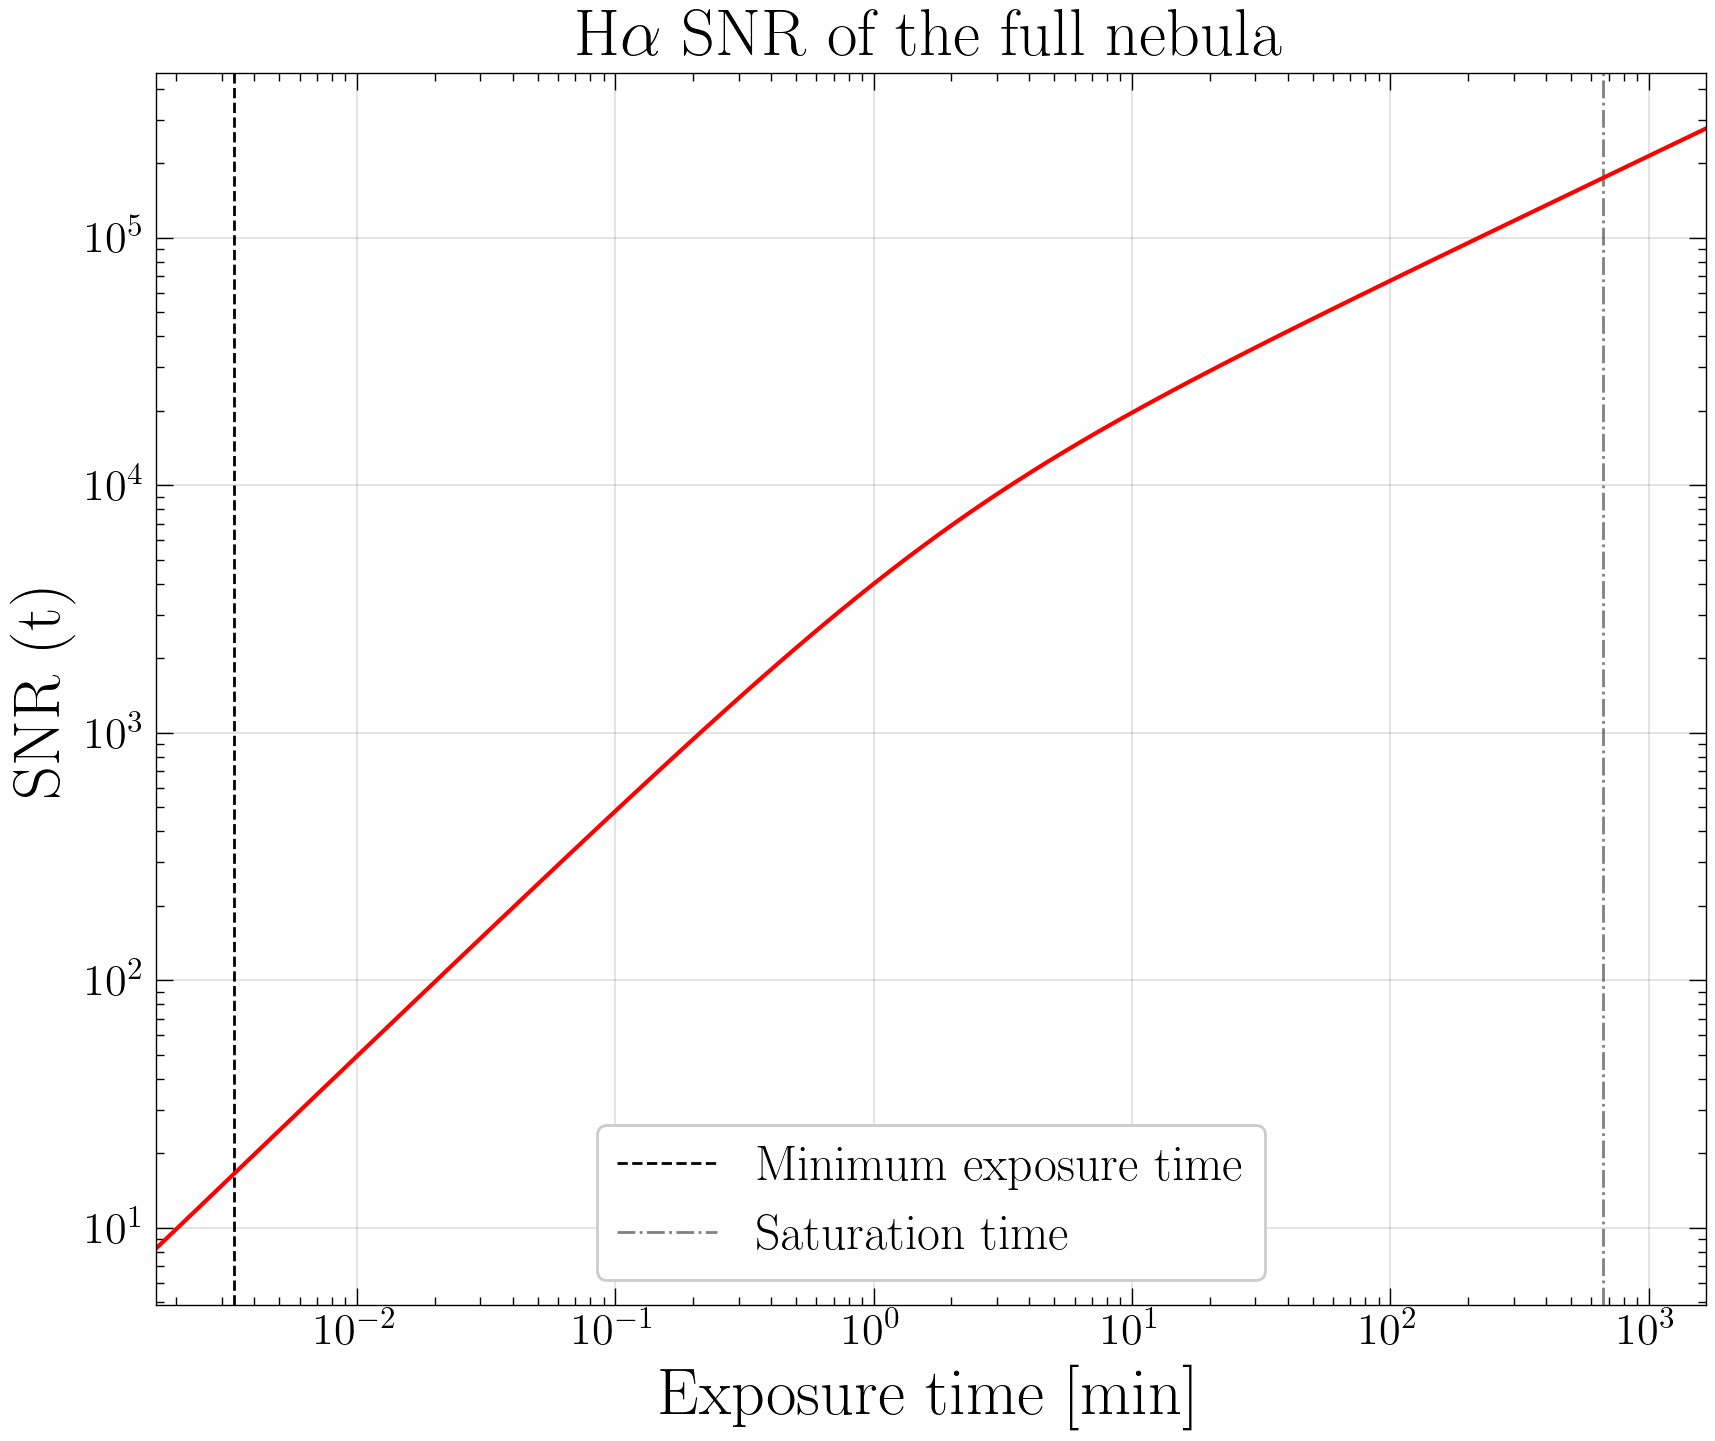

In [14]:
t_exposure = np.logspace(start=-1, stop=5, num=100) # in seconds
SNR_Ha = SNR_func(t_exposure, NPixels_target, Ne_Ha, Ne_bkg_Ha, DarkCurrent, RON)

plt.title('H$\\alpha$ SNR of the full nebula')
plt.plot(t_exposure/60, SNR_Ha, color='red')
plt.axvline(0.2/60, color='black', linestyle='--', linewidth=1, label='Minimum exposure time', zorder=0)
plt.axvline(Saturation_pixel/60, color='gray', linestyle='-.', linewidth=1, label='Saturation time', zorder=0)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1/60, 1e5/60)
plt.xlabel('Exposure time [min]')
plt.ylabel('SNR (t)')
plt.legend();

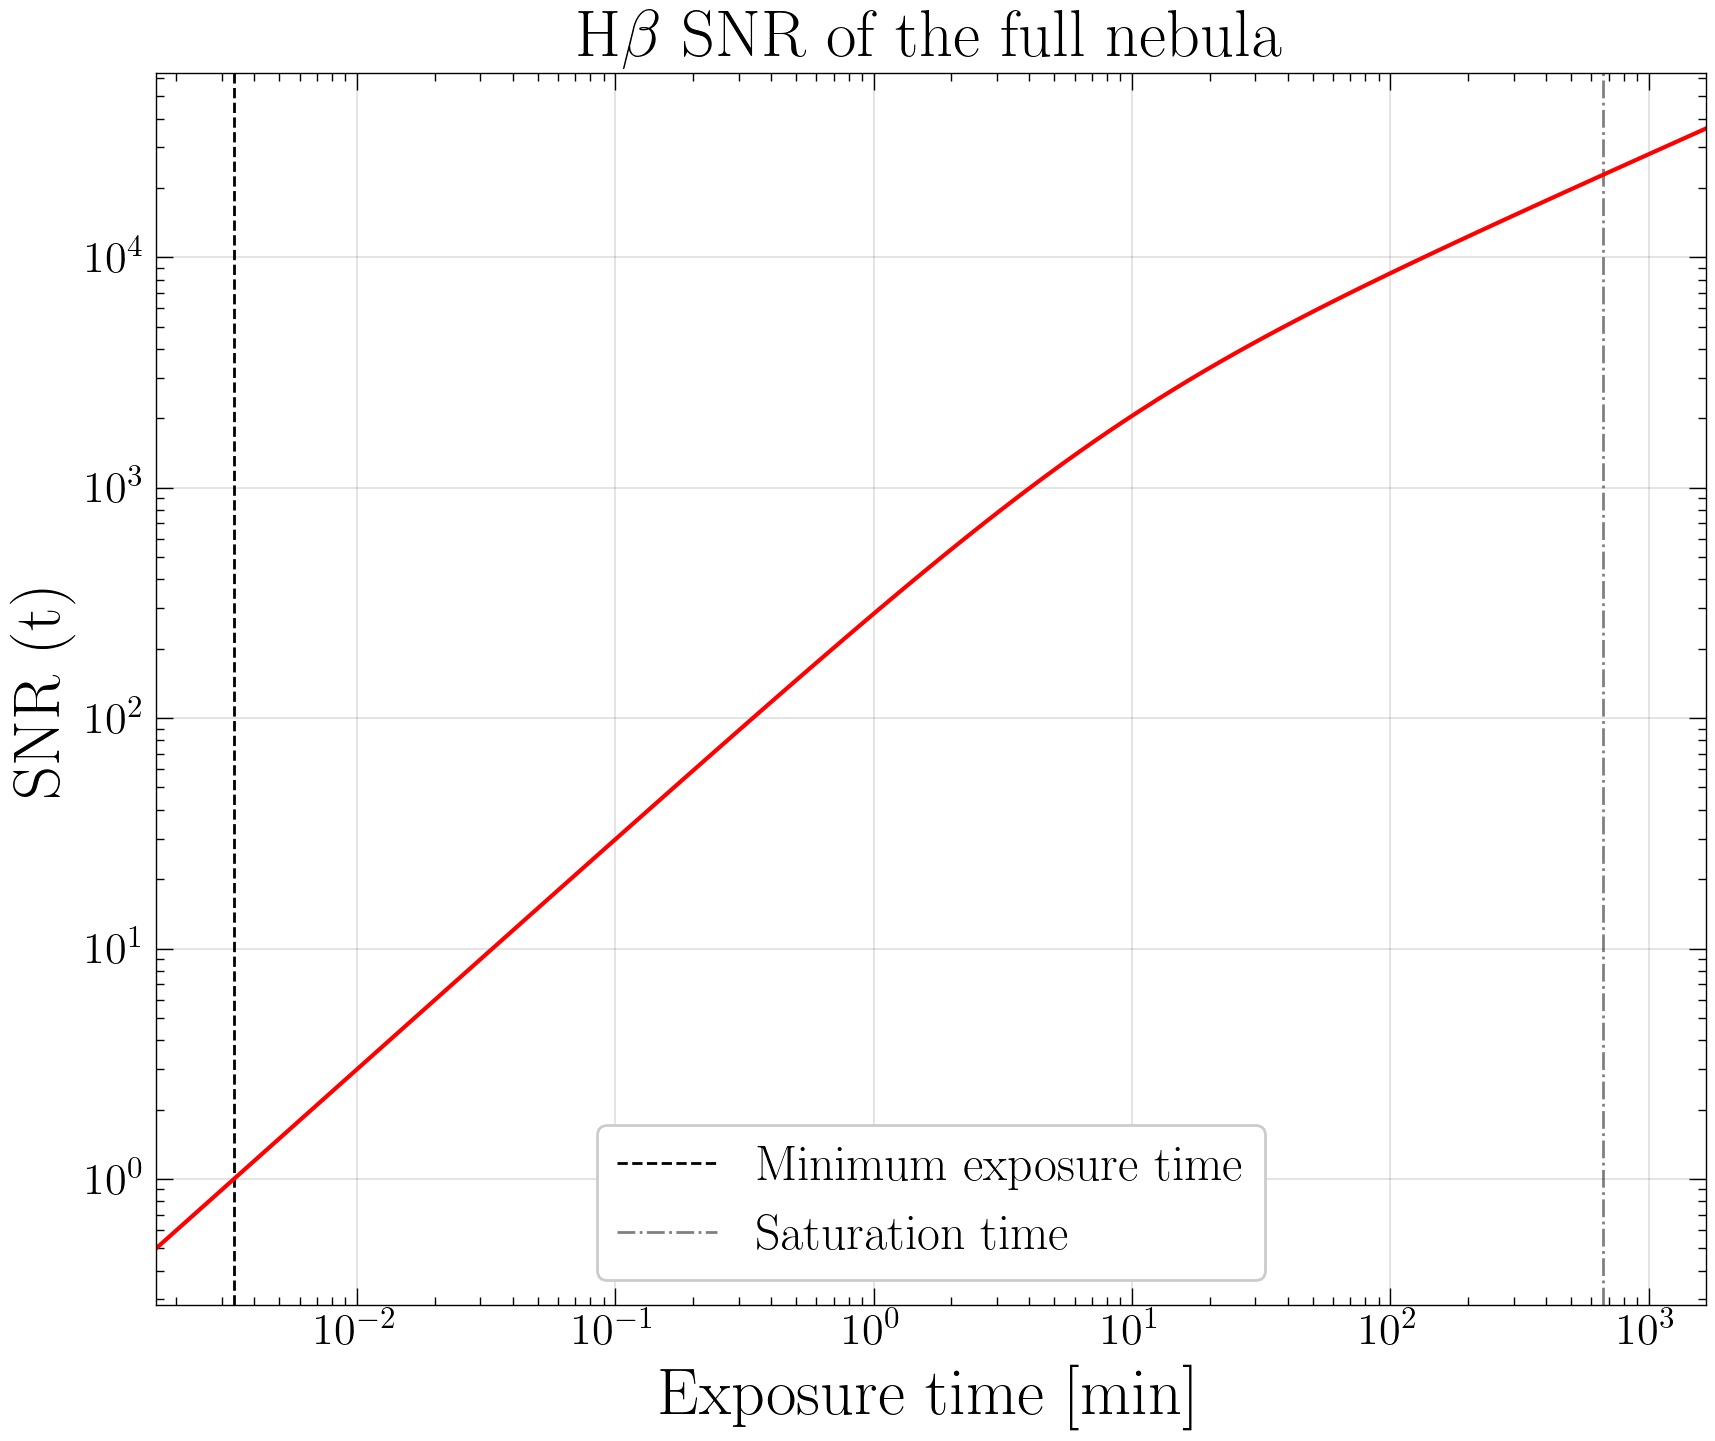

In [15]:
SNR_Hb = SNR_func(t_exposure, NPixels_target, Ne_Hb, Ne_bkg_Hb, DarkCurrent, RON)

plt.title('H$\\beta$ SNR of the full nebula')
plt.plot(t_exposure/60, SNR_Hb, color='red')
plt.axvline(0.2/60, color='black', linestyle='--', linewidth=1, label='Minimum exposure time', zorder=0)
plt.axvline(Saturation_pixel/60, color='gray', linestyle='-.', linewidth=1, label='Saturation time', zorder=0)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1/60, 1e5/60)
plt.xlabel('Exposure time [min]')
plt.ylabel('SNR (t)')
plt.legend();

## Estimating the SNR per pixel

$\text{SNR}_\text{pixel} (\Delta t) = \dfrac{N_\text{e, pixel} \times \Delta t}{\sqrt{N_\text{e, pixel} \times \Delta t + N_\text{e, sky bkg} \times \Delta t + N_\text{e, dc} \times \Delta t + \text{RON}^2}}$

In [16]:
def SNR_func_per_pixel(t, Ne_pixel, Ne_bkg, DarkCurrent, RON):
    Signal = Ne_pixel*t
    Noise = np.sqrt(Ne_pixel*t + Ne_bkg*t + DarkCurrent*t + RON**2)
    SNR = Signal/Noise
    return SNR

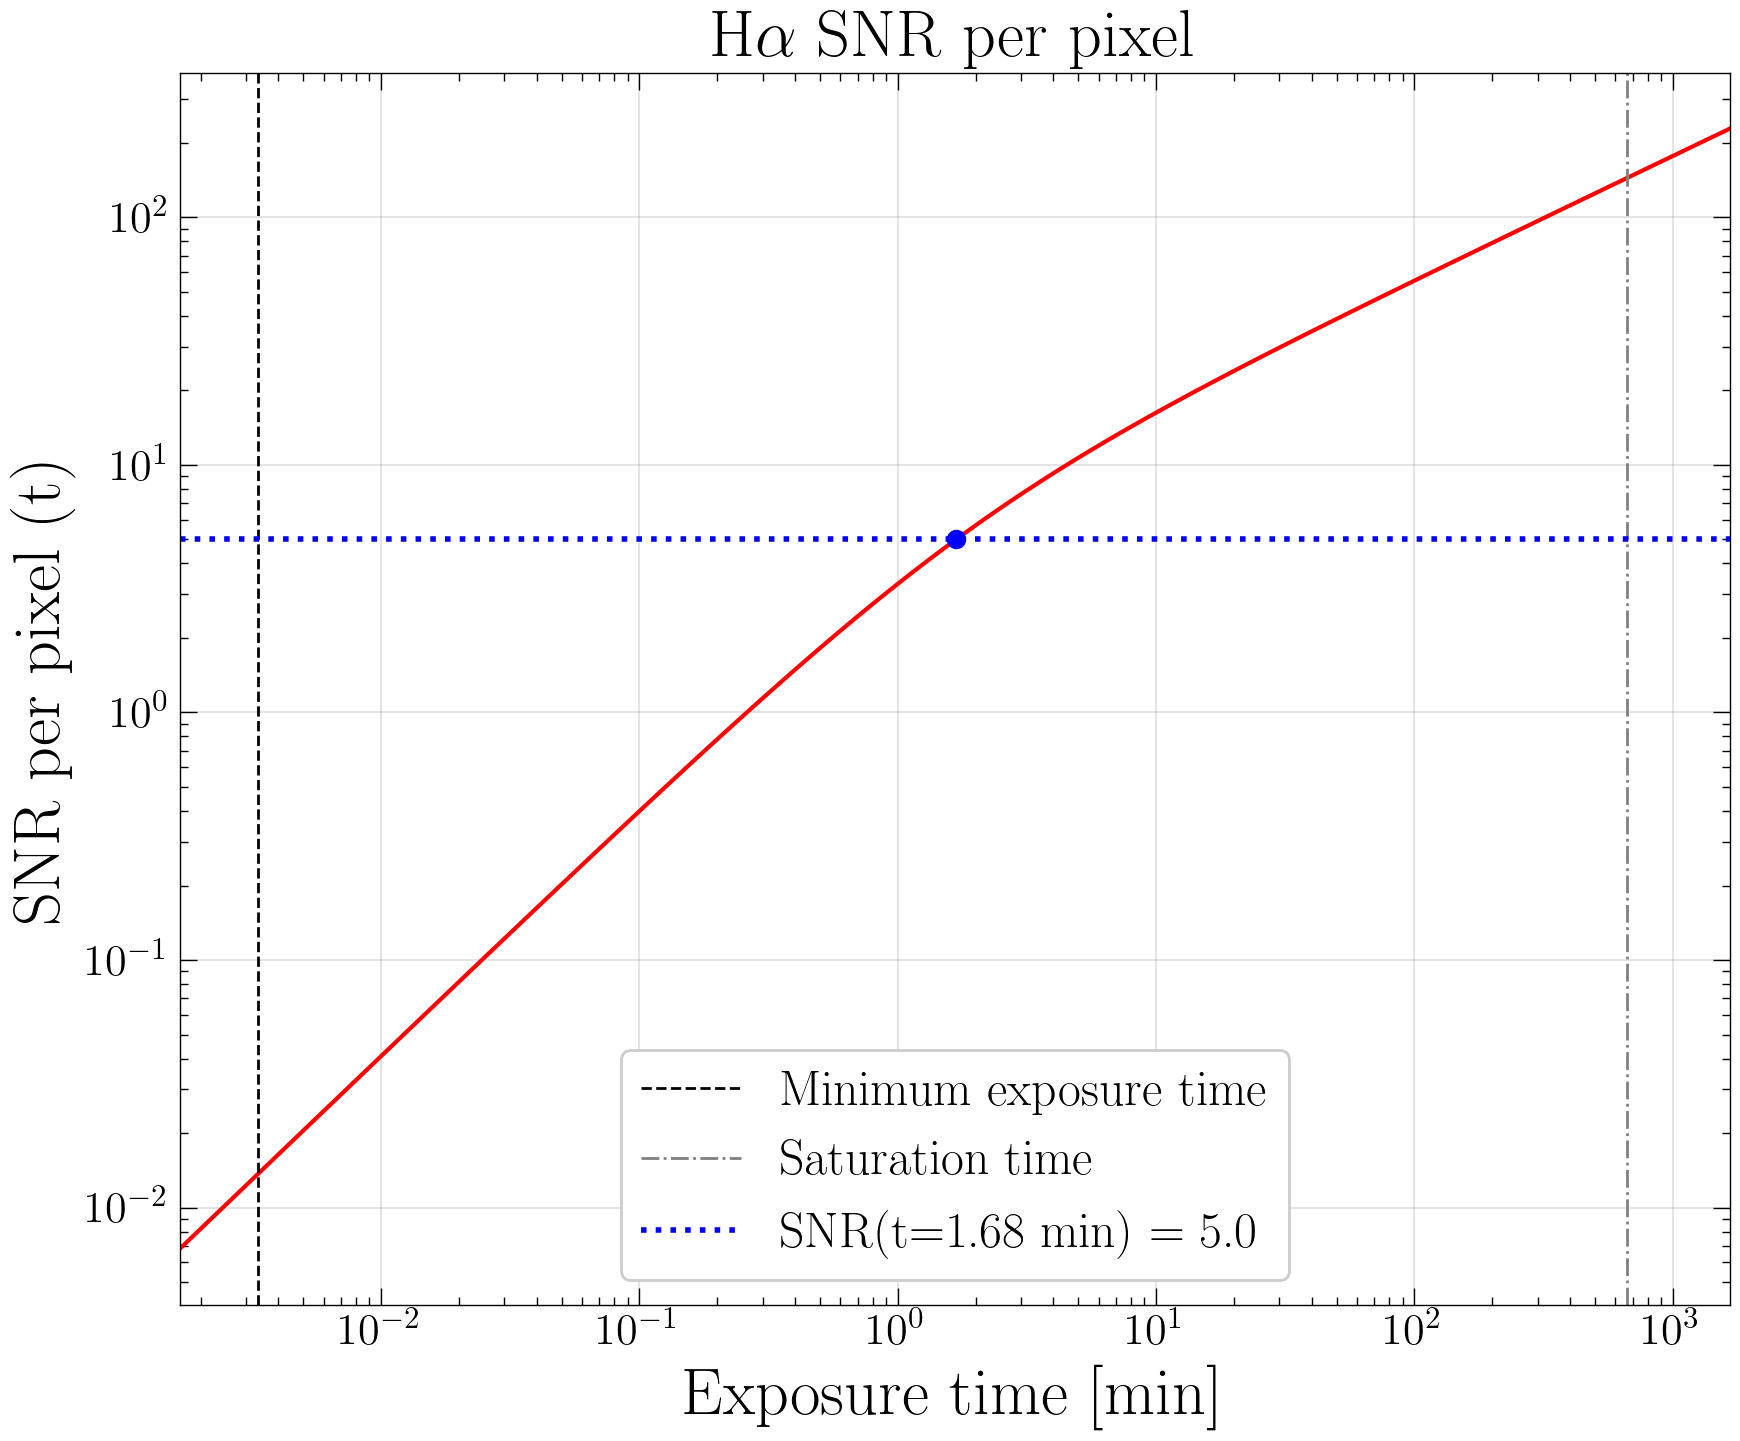

In [17]:
SNR_Ha = SNR_func_per_pixel(t_exposure, Ne_pixel_Ha, Ne_bkg_Ha, DarkCurrent, RON)

SNR_requested = 5
func = lambda t: SNR_func_per_pixel(t, Ne_pixel_Ha, Ne_bkg_Ha, DarkCurrent, RON) - SNR_requested
t_SNR_requested_Ha = brentq(f=func, a=np.min(t_exposure), b=np.max(t_exposure))

plt.title('H$\\alpha$ SNR per pixel')
plt.plot(t_exposure/60, SNR_Ha, color='red')
plt.axvline(0.2/60, color='black', linestyle='--', linewidth=1, label='Minimum exposure time')
plt.axvline(Saturation_pixel/60, color='gray', linestyle='-.', linewidth=1, label='Saturation time')
plt.axhline(SNR_requested, color='blue', linestyle=':', linewidth=2, label=f'SNR(t={t_SNR_requested_Ha/60:.2f} min) = {SNR_requested:.1f}')
plt.plot(t_SNR_requested_Ha/60, SNR_requested, 'o', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1/60, 1e5/60)
plt.xlabel('Exposure time [min]')
plt.ylabel('SNR per pixel (t)')
plt.legend();

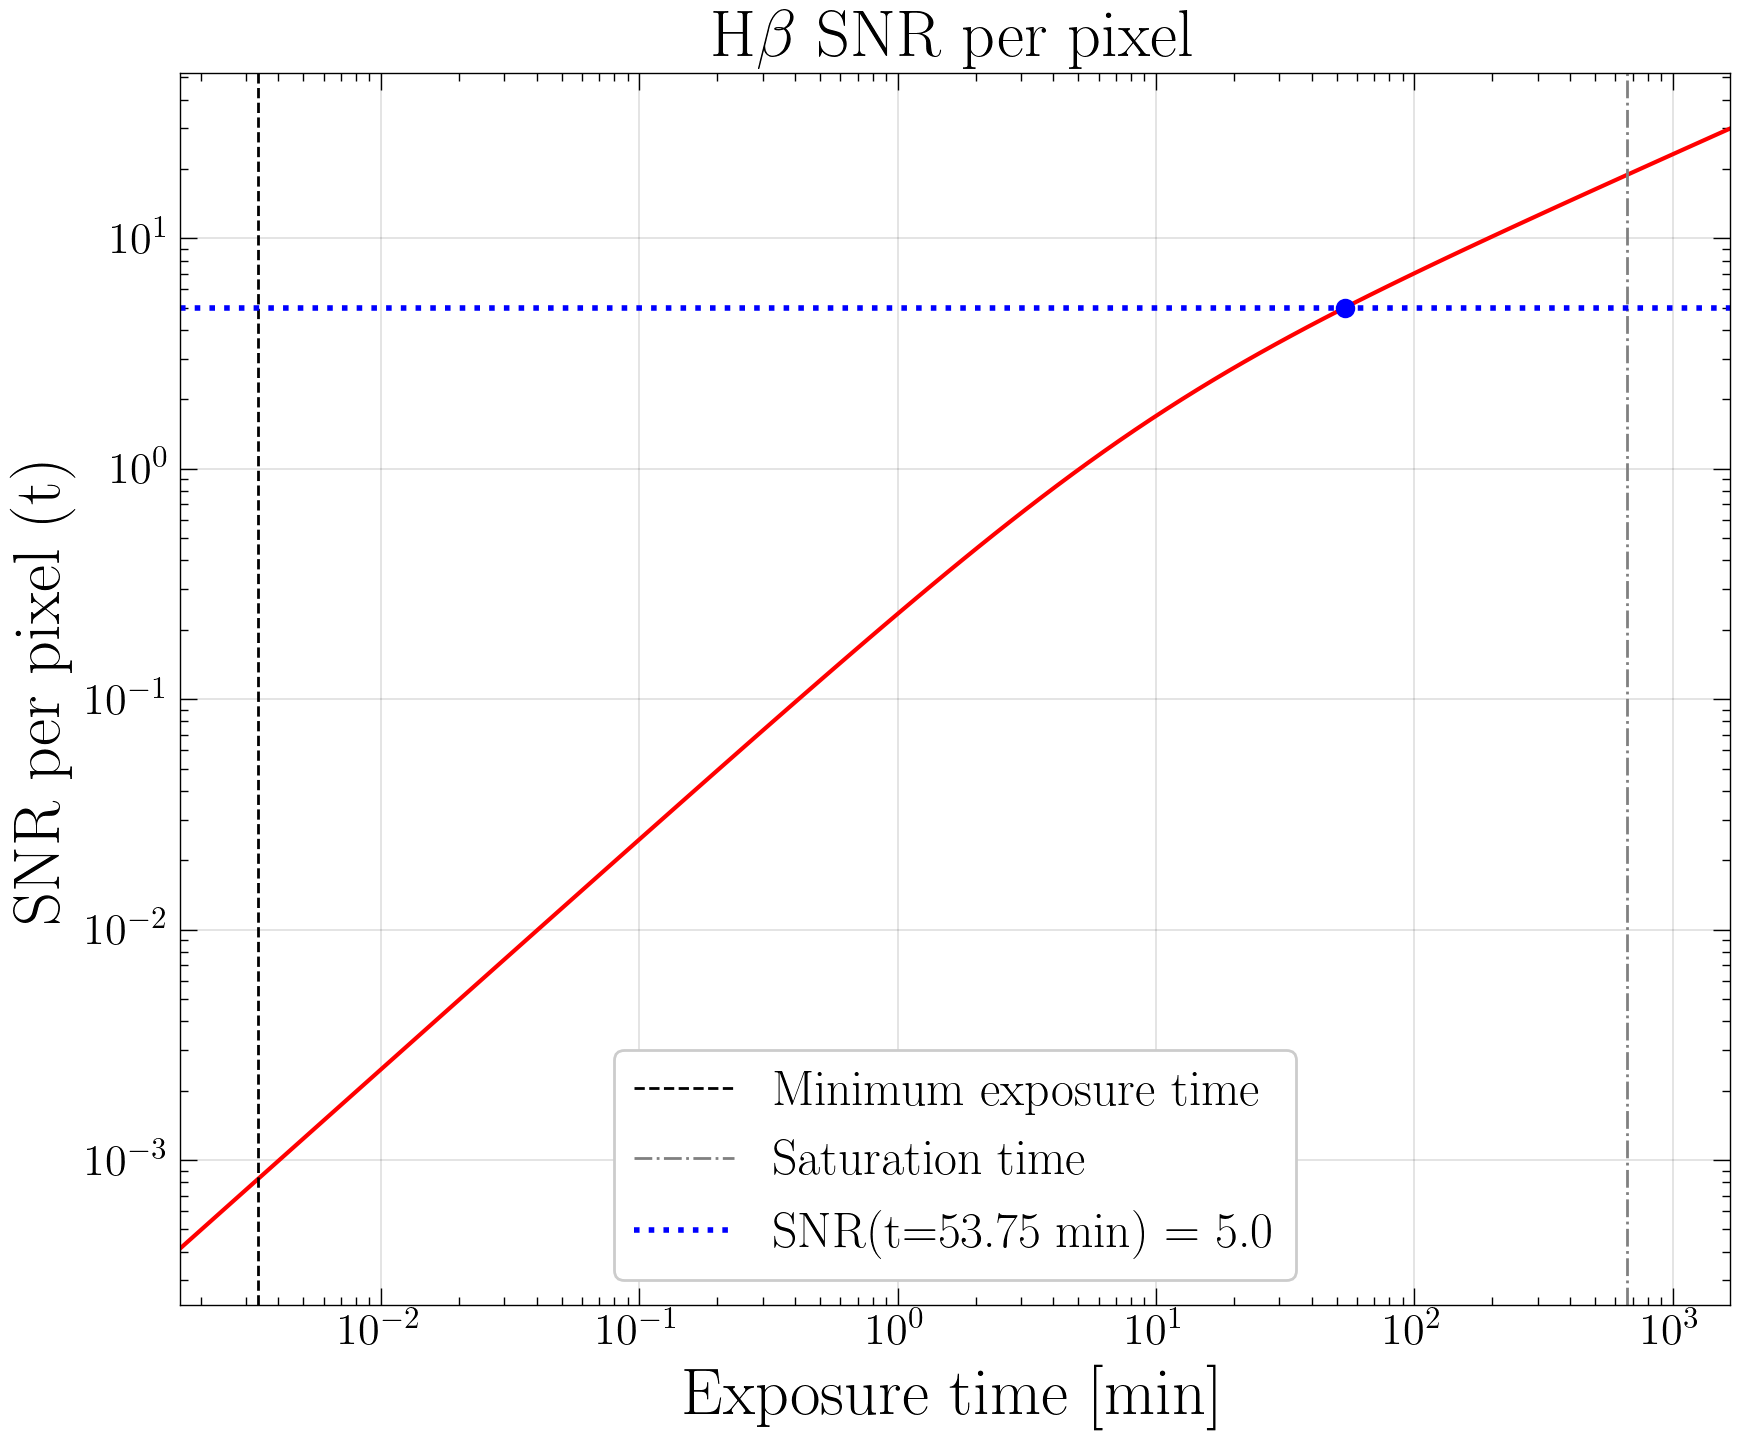

In [18]:
SNR_Hb = SNR_func_per_pixel(t_exposure, Ne_pixel_Hb, Ne_bkg_Hb, DarkCurrent, RON)

SNR_requested = 5
func = lambda t: SNR_func_per_pixel(t, Ne_pixel_Hb, Ne_bkg_Hb, DarkCurrent, RON) - SNR_requested
t_SNR_requested_Hb = brentq(f=func, a=np.min(t_exposure), b=np.max(t_exposure))

plt.title('H$\\beta$ SNR per pixel')
plt.plot(t_exposure/60, SNR_Hb, color='red')
plt.axvline(0.2/60, color='black', linestyle='--', linewidth=1, label='Minimum exposure time')
plt.axvline(Saturation_pixel/60, color='gray', linestyle='-.', linewidth=1, label='Saturation time')
plt.axhline(SNR_requested, color='blue', linestyle=':', linewidth=2, label=f'SNR(t={t_SNR_requested_Hb/60:.2f} min) = {SNR_requested:.1f}')
plt.plot(t_SNR_requested_Hb/60, SNR_requested, 'o', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1/60, 1e5/60)
plt.xlabel('Exposure time [min]')
plt.ylabel('SNR per pixel (t)')
plt.legend();

## SNR of E(B-V)

$R \doteq \dfrac{\text{Im}_{H\alpha}}{\text{Im}_{H\beta}}$

$\sigma_R = \sqrt{\dfrac{1}{\text{Im}_{H\beta}^2}\sigma_{H\alpha}^2 + \dfrac{\text{Im}_{H\alpha}^2}{\text{Im}_{H\beta}^4}\sigma_{H\beta}^2} = 
\dfrac{1}{|\text{Im}_{H\beta}|}\sqrt{\sigma_{H\alpha}^2 + \left(\dfrac{\text{Im}_{H\alpha}}{\text{Im}_{H\beta}}\right)^2 \sigma_{H\beta}^2} =
\dfrac{1}{|\text{Im}_{H\beta}|}\sqrt{\sigma_{H\alpha}^2 + R^2 \sigma_{H\beta}^2}$

In [19]:
def Images_Ratio(image1, image2, image1_err, image2_err):
    ratio = image1/image2
    ratio_err = np.sqrt(image1_err**2 + (ratio*image2_err)**2)/np.abs(image2)
    
    return ratio, ratio_err

$\text{EBV} \doteq 1.97 \log_{10} \left(\dfrac{R}{2.86}\right)$

$\sigma_{\text{EBV}} = 1.97 \dfrac{1}{\ln{10}} \dfrac{1}{|R|} \sigma_R$

In [20]:
def EBV(image_R, image_R_err):
    image_R_temp = image_R.copy()
    image_R_temp[image_R_temp < 2.86] = 2.86
    
    EBV = 1.97*np.log10(image_R_temp/2.86)
    EBV_err = 1.97/np.log(10)/np.abs(image_R_temp)*image_R_err
    
    return EBV, EBV_err

We have to compute the errors on the electron/s values

In [21]:
def Ne_err_func_per_pixel(t, Ne_pixel, Ne_bkg, DarkCurrent, RON):
    Noise = np.sqrt(Ne_pixel*t + Ne_bkg*t + DarkCurrent*t + RON**2)
    Ne_pixel_err = Noise/t
    return Ne_pixel_err

In [22]:
t_exposure = np.logspace(start=1, stop=4, num=100) # in seconds

Ne_pixel_Ha_err = Ne_err_func_per_pixel(t_exposure, Ne_pixel_Ha, Ne_bkg_Ha, DarkCurrent, RON)
Ne_pixel_Hb_err = Ne_err_func_per_pixel(t_exposure, Ne_pixel_Hb, Ne_bkg_Hb, DarkCurrent, RON)

In order to obtain meaningful estimates of E(B-V), we have to go back to fluxes in physical units. \
We also have to multiply the fluxes by the effective width of the emission-line filters. \
Finally, we have to rebin the pixels to obtain a sufficiently high SNR.

In [23]:
Rebin_new_pixel_side = 9

flux_Ha = Ne_pixel_Ha * 10**(-C_calibration_Ha) * FWHM_Ha
flux_Hb = Ne_pixel_Hb * 10**(-C_calibration_Hb) * FWHM_Hb

flux_Ha_err = Ne_pixel_Ha_err * 10**(-C_calibration_Ha) * FWHM_Ha / Rebin_new_pixel_side
flux_Hb_err = Ne_pixel_Hb_err * 10**(-C_calibration_Hb) * FWHM_Hb / Rebin_new_pixel_side

print(f'{flux_Ha:.2e} erg/s/cm^2')
print(f'{flux_Hb:.2e} erg/s/cm^2')
print(f'{flux_Ha/flux_Hb:.2f}')

5.66e-16 erg/s/cm^2
1.78e-16 erg/s/cm^2
3.18


In [24]:
t_exposure_meshgrid_x, t_exposure_meshgrid_y = np.meshgrid(t_exposure, t_exposure)
flux_Ha_meshgrid, flux_Hb_meshgrid = np.meshgrid(flux_Ha, flux_Hb)
flux_Ha_err_meshgrid, flux_Hb_err_meshgrid = np.meshgrid(flux_Ha_err, flux_Hb_err)

In [25]:
Ratio_Ha_Hb, Ratio_Ha_Hb_err = Images_Ratio(flux_Ha_meshgrid, flux_Hb_meshgrid, flux_Ha_err_meshgrid, flux_Hb_err_meshgrid)

EBV_Ha_Hb, EBV_Ha_Hb_err = EBV(Ratio_Ha_Hb, Ratio_Ha_Hb_err)
EBV_Ha_Hb_SNR = EBV_Ha_Hb / EBV_Ha_Hb_err

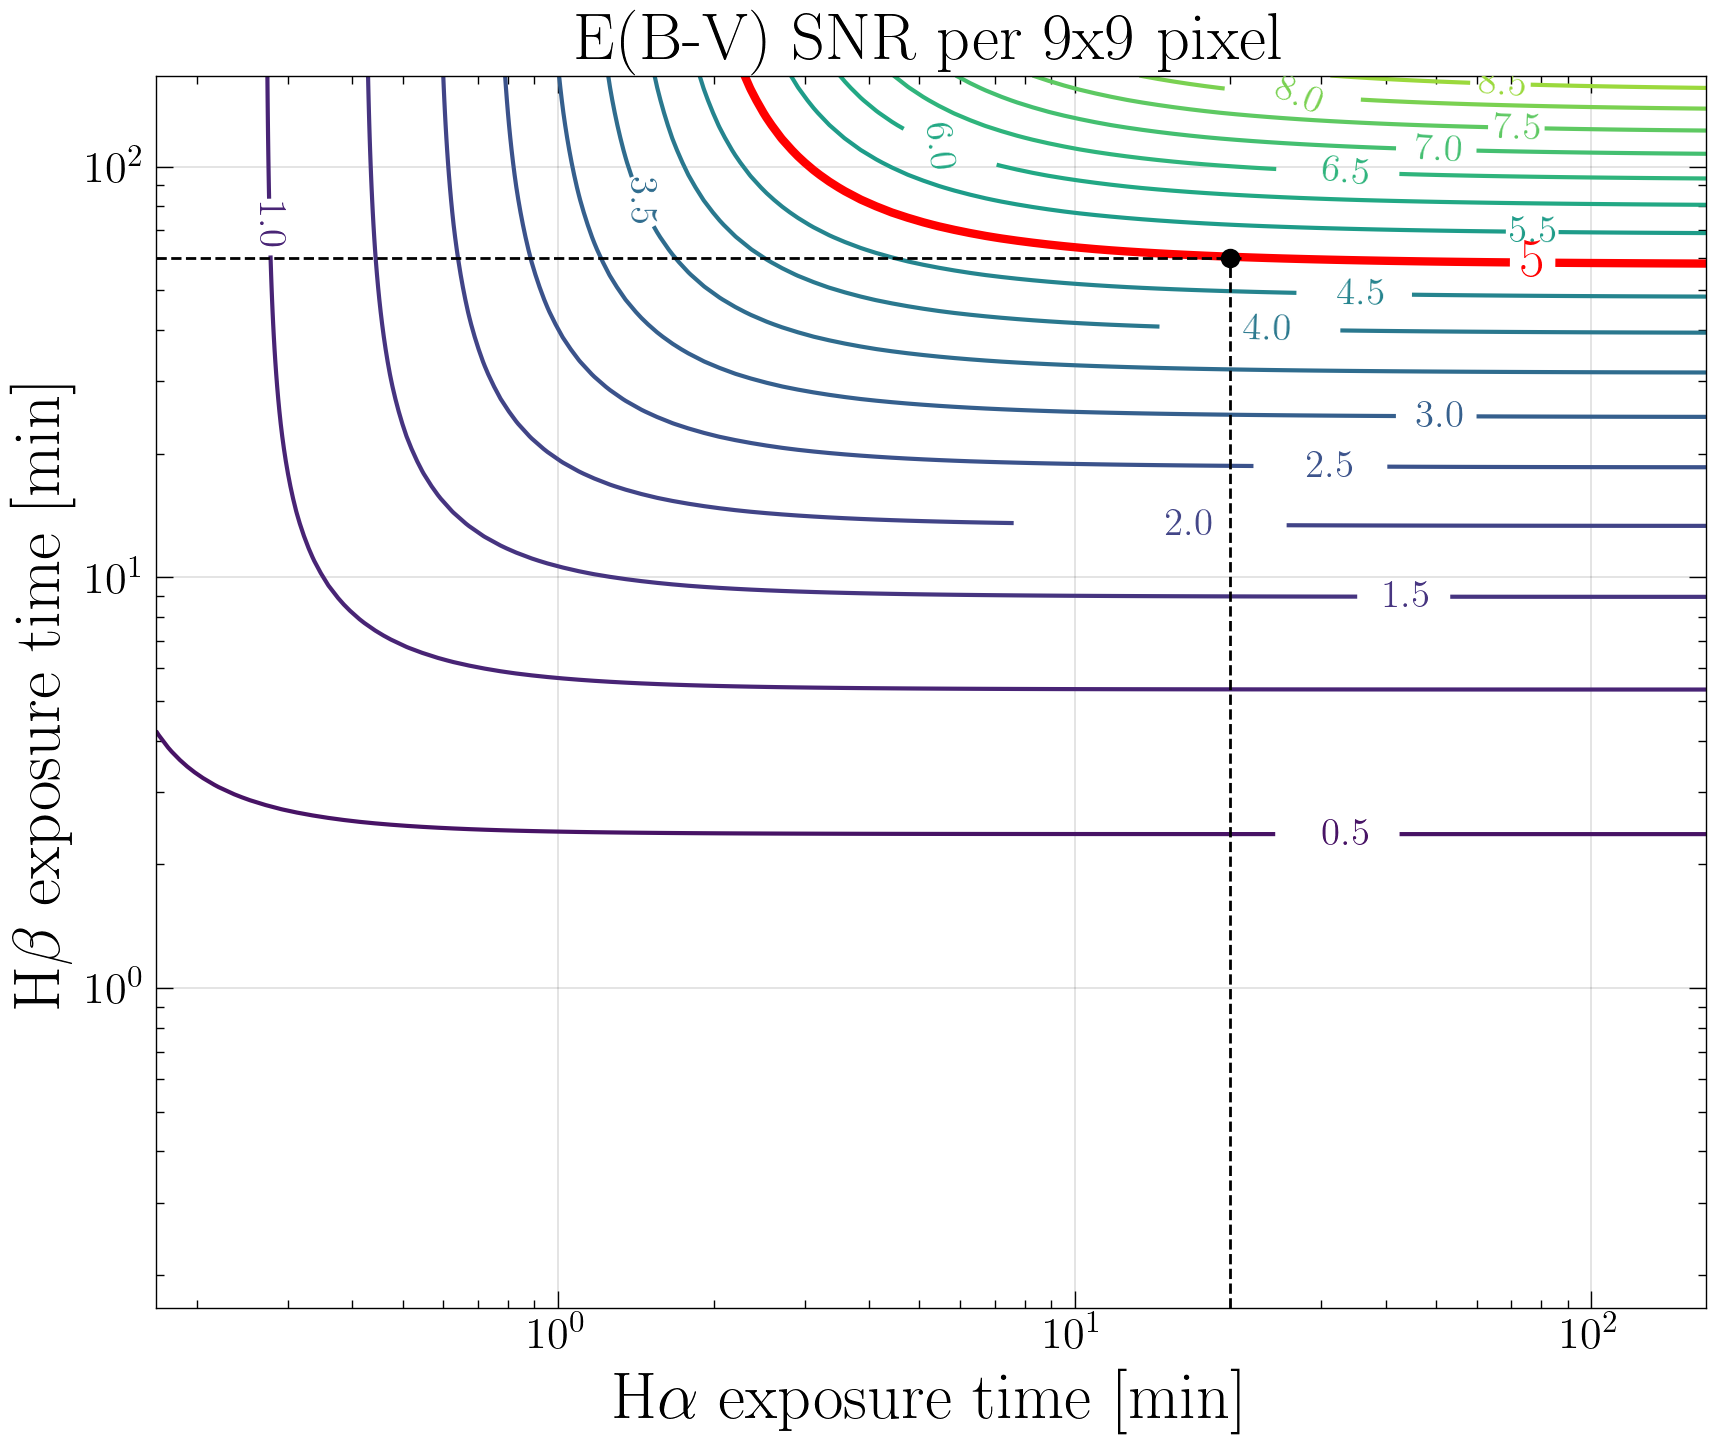

In [26]:
cs= plt.contour(t_exposure_meshgrid_x/60, t_exposure_meshgrid_y/60, EBV_Ha_Hb_SNR, 
                levels=np.delete(np.linspace(0, 10, 21), 21//2), cmap='viridis')
plt.clabel(cs, fontsize=14, inline_spacing=30)

cs= plt.contour(t_exposure_meshgrid_x/60, t_exposure_meshgrid_y/60, EBV_Ha_Hb_SNR, levels=[5], colors='red', linewidths=3)
plt.clabel(cs, fontsize=20, inline_spacing=30)

plt.axvline(20, 0, 0.85, color='black', linestyle='--', linewidth=1)
plt.axhline(60, 0, 0.7, color='black', linestyle='--', linewidth=1)
plt.plot(20, 60, 'o', color='black')

plt.title(f'E(B-V) SNR per {Rebin_new_pixel_side}x{Rebin_new_pixel_side} pixel')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e1/60, 1e4/60)
plt.ylim(1e1/60, 1e4/60)
plt.xlabel('H$\\alpha$ exposure time [min]')
plt.ylabel('H$\\beta$ exposure time [min]');